In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [3]:
train=pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv',
                 parse_dates=['date'],infer_datetime_format=True)
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


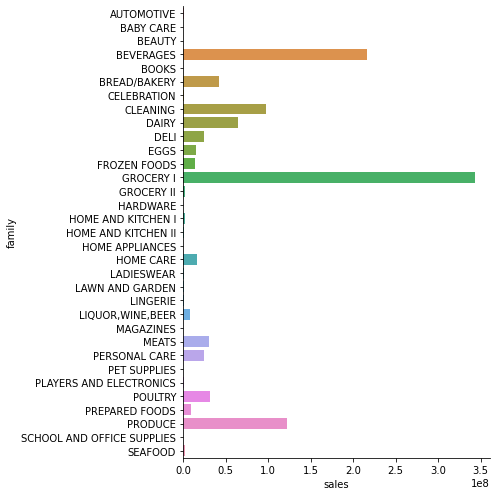

In [4]:
f=train.groupby(by=['family']).sum().groupby(level=[0]).cumsum().reset_index()
sns.catplot(data=f,x='sales',y='family',kind='bar',size=7)
plt.show()

In [5]:
train['date'] = train.date.dt.to_period('D')
sales = train.set_index(['store_nbr', 'family', 'date']).sort_index()
sales

id  sales  onpromotion
store_nbr family     date                                   
1         AUTOMOTIVE 2013-01-01        0    0.0            0
                     2013-01-02     1782    2.0            0
                     2013-01-03     3564    3.0            0
                     2013-01-04     5346    3.0            0
                     2013-01-05     7128    5.0            0
...                                  ...    ...          ...
54        SEAFOOD    2017-08-11  2993627    0.0            0
                     2017-08-12  2995409    1.0            1
                     2017-08-13  2997191    2.0            0
                     2017-08-14  2998973    0.0            0
                     2017-08-15  3000755    3.0            0

[3000888 rows x 3 columns]

# **Trend**

In [6]:
from pathlib import Path
from warnings import simplefilter
simplefilter("ignore")

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [7]:
average_sales = (sales.groupby('date').mean().squeeze())
average_sales=average_sales.drop(['id','onpromotion'],axis=1)

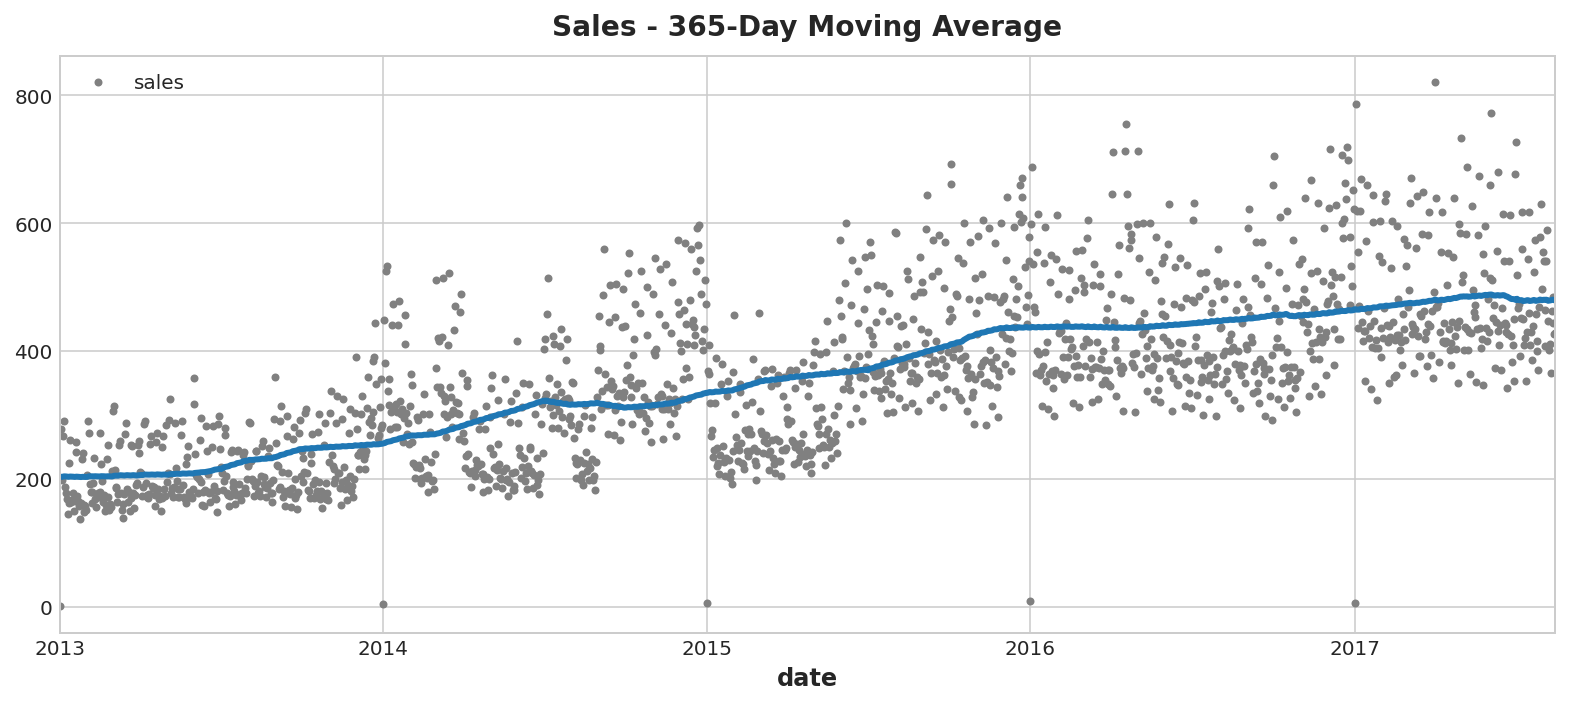

In [8]:
moving_average=average_sales['sales'].rolling(window=365,
                            center=True,
                            min_periods=183,).mean()

ax = average_sales.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Sales - 365-Day Moving Average", legend=False,
);

In [9]:
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression


dp=DeterministicProcess(index=average_sales.index,order=1)

X=dp.in_sample()
y=average_sales['sales']

model=LinearRegression()
model.fit(X,y)

y_pred = pd.Series(model.predict(X), index=X.index)


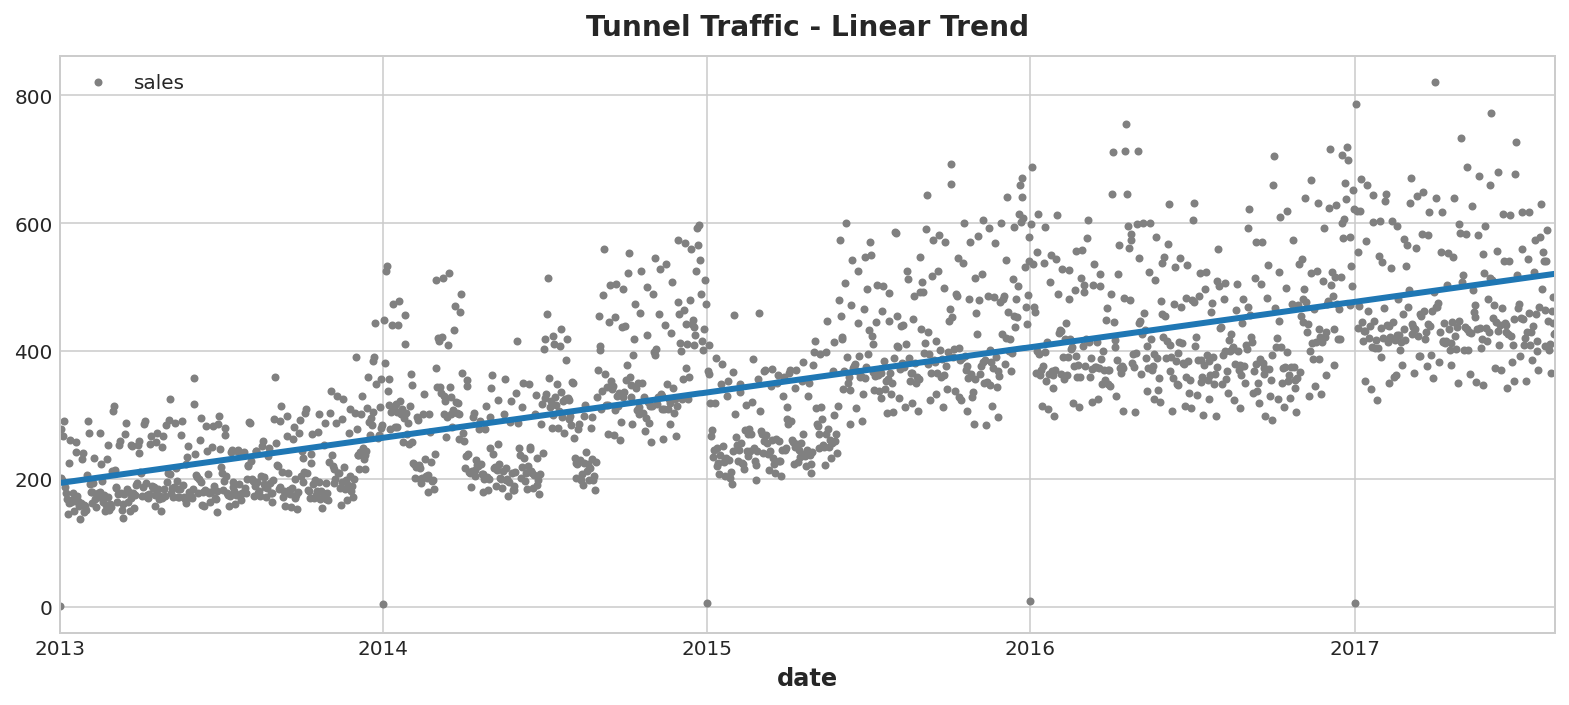

In [10]:
ax = average_sales.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [11]:
X = dp.out_of_sample(steps=180)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2017-08-16    521.513055
2017-08-17    521.707402
2017-08-18    521.901749
2017-08-19    522.096096
2017-08-20    522.290443
Freq: D, dtype: float64

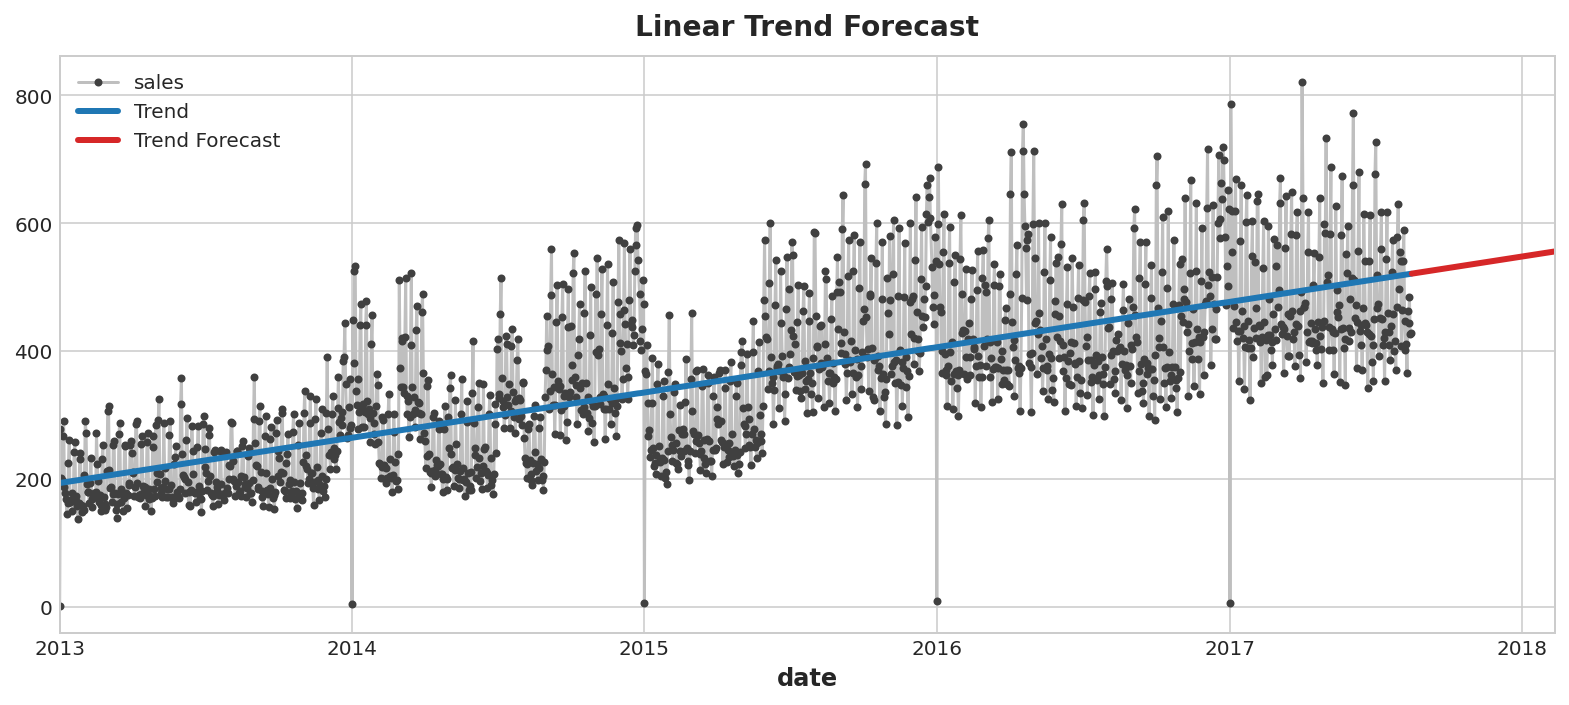

In [12]:
ax = average_sales.plot(title="Linear Trend Forecast", **plot_params)
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

# **Seasonality**

In [13]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
        )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

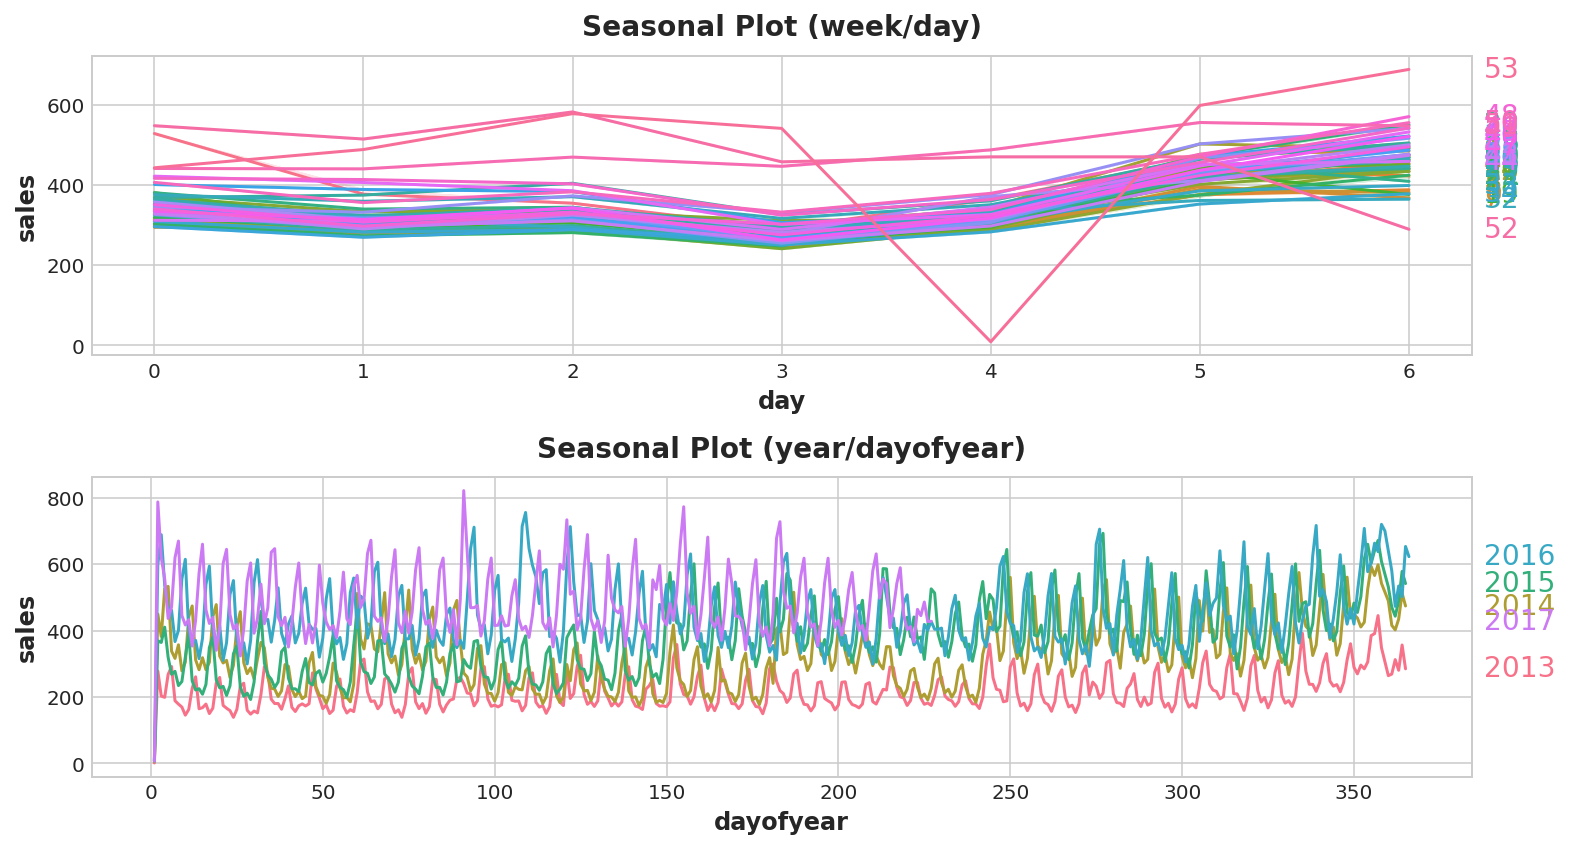

In [14]:
X=average_sales.copy()

X['day']=X.index.dayofweek
X['week']=X.index.week

X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);

In [15]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        ["Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

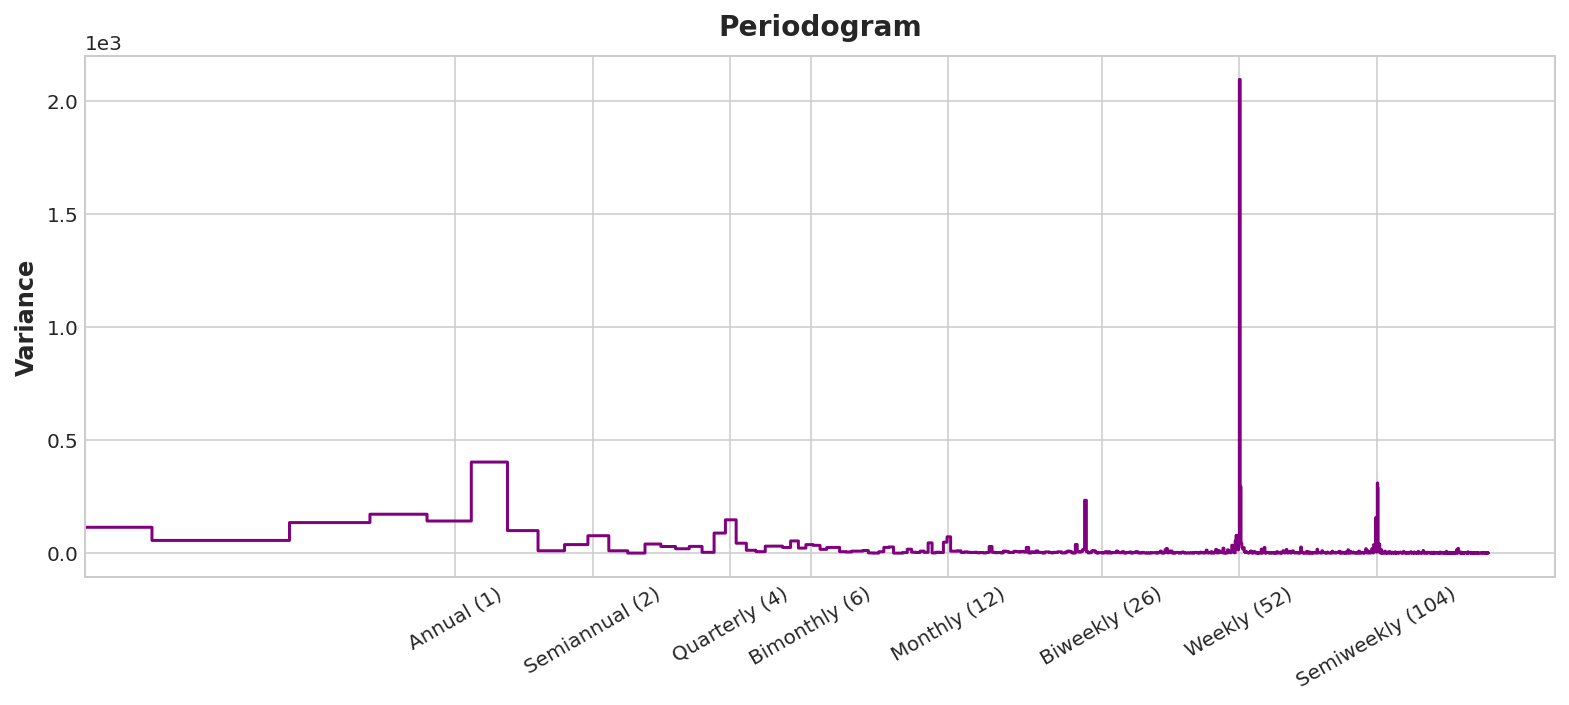

In [16]:
plot_periodogram(average_sales.sales);

In [17]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  

dp = DeterministicProcess(
    index=average_sales.index,
    constant=True,               
    order=1,                     
    seasonal=True,               
    additional_terms=[fourier],  
    drop=True,                   
)

X = dp.in_sample() 
y=average_sales['sales']

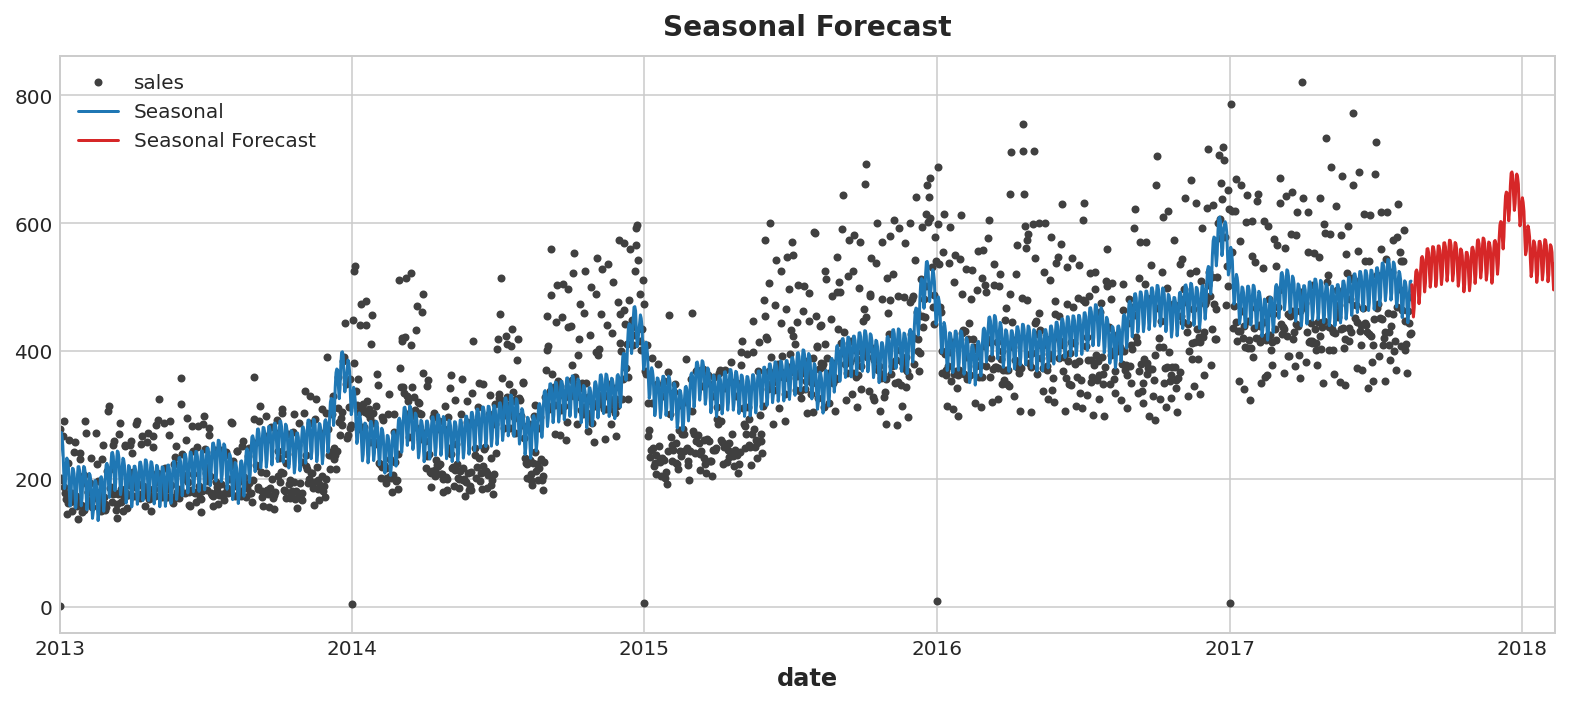

In [18]:
model=LinearRegression(fit_intercept=False)
model.fit(X,y)
y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=180)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()